In [21]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!cp -r "/content/drive/MyDrive/tree_coco.zip" /content/


In [24]:
!unzip /content/tree_coco.zip -d /content/


Archive:  /content/tree_coco.zip
replace /content/tree_coco/test/17197-824e56_jpg.rf.b3bbd7effc3f1a8a722395cc6e0752c7.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

In [26]:
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

train_dataset = get_coco_dataset(
    img_dir="/content/tree_coco/train",
    ann_file="/content/tree_coco/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/tree_coco/valid",
    ann_file="/content/tree_coco/valid/_annotations.coco.json"
)




train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [27]:

def get_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")


    in_features = model.roi_heads.box_predictor.cls_score.in_features


    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [28]:
num_classes = 2
model = get_model(num_classes)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [30]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [31]:
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 0.6605
Model saved: fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.2113
Model saved: fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.3743
Model saved: fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.3027
Model saved: fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.3104
Model saved: fasterrcnn_resnet50_epoch_5.pth


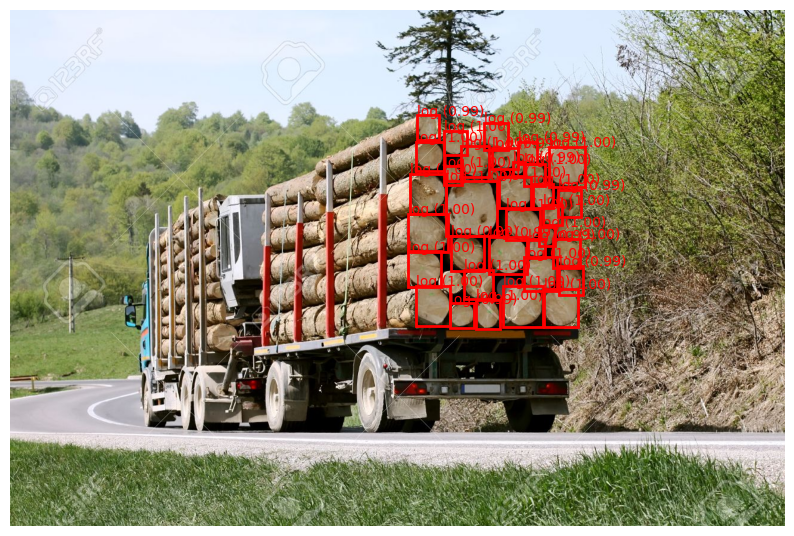

Number of Wood logs detected: 33


In [35]:

def get_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



num_classes = 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



model = get_model(num_classes)
model.load_state_dict(torch.load("/content/fasterrcnn_resnet50_epoch_5.pth"))
model.to(device)
model.eval()

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image_tensor.to(device)




image_path = "/content/test3.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():
    prediction = model(image_tensor)


COCO_CLASSES = {0: "Background", 1: "log"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")


def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()


    threshold = 0.99
    num_boxes = sum(score > threshold for score in scores)




    plt.figure(figsize=fig_size)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            plt.imshow(image)
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')


    plt.axis('off')
    plt.show()
    print(f"Number of Wood logs detected: {num_boxes}")
draw_boxes(Image.open(image_path), prediction, fig_size=(10,10))
